<a href="https://colab.research.google.com/github/Haebuk/dataminingTP/blob/main/TermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 아파트 실거래가 예측

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re
from gensim.models.word2vec import Word2Vec
!pip install konlpy -q
from konlpy.tag import Okt

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm
!apt-get update -qq
!apt-get install fonts-nanum* -qq
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

     |████████████████████████████████| 19.4MB 1.2MB/s 
     |████████████████████████████████| 92kB 11.2MB/s 
     |████████████████████████████████| 450kB 56.7MB/s 
NanumGothic Eco


## Data Load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/input/dataminingTP/'
train_df = pd.read_csv(PATH + 'train_df_regex.csv')
test_df = pd.read_csv(PATH + 'test_df_regex.csv')
o_train_df = pd.read_csv(PATH + 'train.csv')

- exclusive_use_area: 전용면적(한 세대만 독점적으로 사용하는 공간)
- transaction_real_price: 실거래가(단위:만원, 타겟 값, train만 존재)
- transaction_year_month: 거래년월
- transaction_date: 거래일
- floor: 층 

- 데이터가 거래시간 순으로 이루어져 있음

### regex preprocessing
- apt 이름에 존재하는 괄호 + 괄호안 내용 제거

In [ ]:
# 괄호와 괄호안내용 제거
#regex = "\(.*\)|\s-\s.*"
#for i in tqdm(range(len(train_df)), position=0, leave=True):
#    train_df['apt'][i] = re.sub(regex, '', train_df['apt'][i])

#train_df.to_csv('train_df_regex.csv', index=False)


In [ ]:
# 괄호와 괄호안내용 제거
#regex = "\(.*\)|\s-\s.*"
#for j in tqdm(range(len(test_df)),position=0, leave=True):
#    test_df['apt'][i] = re.sub(regex, '', test_df['apt'][i])
    
#test_df.to_csv('test_df_regex.csv', index=False)

## Preprocessing
### Train and Test set

In [ ]:
train_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500


In [ ]:
test_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,1145756,10453,서울특별시,목동,938,청학,목동 938 청학,35.55,2002,201711,11~20,2
1,1198704,989,부산광역시,초량동,1143-8,고관맨션,초량동 1143-8 고관맨션,68.72,1977,201708,21~31,2
2,1222384,8597,부산광역시,괴정동,447-13,우림그린,괴정동 447-13 우림그린,72.54,1989,201710,11~20,2


In [ ]:
train_df.describe() 

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  object 
 3   dong                    1216553 non-null  object 
 4   jibun                   1216553 non-null  object 
 5   apt                     1215092 non-null  object 
 6   addr_kr                 1216553 non-null  object 
 7   exclusive_use_area      1216553 non-null  float64
 8   year_of_completion      1216553 non-null  int64  
 9   transaction_year_month  1216553 non-null  int64  
 10  transaction_date        1216553 non-null  object 
 11  floor                   1216553 non-null  int64  
 12  transaction_real_price  1216553 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 120.7+ M

- train_df 결측치는 없음
- 1961년 ~ 2017년 완공 건물
- 9.26m^2 ~ 424.32m^2 전용면적
- Floor의 경우 음의 값 존재.
- 실거래가는 100만원부터 820억까지 존재

In [ ]:
train_df.loc[train_df['transaction_real_price']==820000]

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
23603,23603,11320,서울특별시,한남동,810,한남더힐,한남동 810 한남더힐,244.749,2011,201612,21~31,3,820000


In [ ]:
test_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,5.463000e+03,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000
mean,1.167126e+06,6287.570932,79.495250,2000.431082,201710.228446,8.266886
std,4.075365e+04,3624.756304,32.935434,9.982040,2.798195,6.082475
min,1.092791e+06,12.000000,10.321500,1961.000000,201701.000000,-1.000000
25%,1.134296e+06,3278.000000,59.760000,1995.000000,201709.000000,4.000000
50%,1.167937e+06,6091.000000,81.720000,2002.000000,201712.000000,7.000000
75%,1.202560e+06,9416.500000,84.970000,2007.000000,201712.000000,11.000000
max,1.234930e+06,12652.000000,273.860000,2017.000000,201712.000000,55.000000


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5463 entries, 0 to 5462
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          5463 non-null   int64  
 1   apartment_id            5463 non-null   int64  
 2   city                    5463 non-null   object 
 3   dong                    5463 non-null   object 
 4   jibun                   5463 non-null   object 
 5   apt                     5463 non-null   object 
 6   addr_kr                 5463 non-null   object 
 7   exclusive_use_area      5463 non-null   float64
 8   year_of_completion      5463 non-null   int64  
 9   transaction_year_month  5463 non-null   int64  
 10  transaction_date        5463 non-null   object 
 11  floor                   5463 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 512.3+ KB


### apart

In [ ]:
train_df['apt'].value_counts()[:30]

현대          17716
한신          10135
삼성           6771
대우           6390
신동아          6386
두산           5801
우성           5781
주공2          5669
삼성래미안        5483
벽산           4651
대림           4582
동원로얄듀크       4430
경남           4030
삼환           3896
극동           3771
삼익           3583
롯데캐슬         3570
쌍용           3409
코오롱          3320
한양           3231
오륙도에스케이뷰     3220
성원           3112
파크리오         3094
청구           3006
몰운대          2886
동아           2804
경남아너스빌       2657
현대3          2595
삼정그린코아       2585
대림e-편한세상     2583
Name: apt, dtype: int64

In [ ]:
# 같은 아파트 이름을 갖는 수를 저장하는 apt_counts 열 생성
train_df['apt_counts'] = 0
train_df.groupby('apt')['apt_counts'].count()
train_df = pd.merge(train_df, train_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

test_df['apt_counts'] = 0
test_df.groupby('apt')['apt_counts'].count()
test_df = pd.merge(test_df, test_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

train_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13.0
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000,1.0
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500,13.0


In [ ]:
train_df.shape

(1216553, 14)

In [ ]:
train_df['apt'].value_counts()[:10]

현대       17716
한신       10135
삼성        6771
대우        6390
신동아       6386
두산        5801
우성        5781
주공2       5669
삼성래미안     5483
벽산        4651
Name: apt, dtype: int64

- top10 시공사 + 데이터에서 가장 많이 나오는 아파트 20개의 이름을 통일

In [ ]:
train_df['top10'] = 0
test_df['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

train_df['apt'] = train_df['apt'].fillna('others')
for i, brand in enumerate(top10):
    train_df.loc[train_df['apt'].str.contains(brand), 'top10'] = 1
    test_df.loc[test_df['apt'].str.contains(brand), 'top10'] = 1


In [ ]:
train_df.head(1)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts,top10
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13.0,0


In [ ]:
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']
apt_names_list = top10 + apt_names

train_df['transformed'] = False
test_df['transformed'] = False

for a in apt_names_list:
    train_df.loc[train_df['apt'].str.contains(a), 'apt'] = a
    test_df.loc[test_df['apt'].str.contains(a), 'apt'] = a
    train_df.loc[train_df['apt'].str.contains(a), 'transformed'] = True
    test_df.loc[test_df['apt'].str.contains(a), 'transformed'] = True

#아파트 이름이 변경되지 않았을 경우 others로 변경
for a in apt_names:
    train_df.loc[~train_df['transformed'], 'apt'] = 'others'
    test_df.loc[~test_df['transformed'] , 'apt'] = 'others'

In [ ]:
train_df['apt'].value_counts()

others          653503
현대               81824
주공               65937
래미안              32743
한신               27481
벽산               26968
우성               24524
롯데캐슬             24053
삼성               20067
sk|SK|에스케이       19709
두산               19501
삼익               18708
푸르지오             18416
쌍용               18256
대림               18194
대우               17786
이편한|e편한|e-편한     14337
신동아              14049
힐스테이트            11985
자이               11719
엘지               10938
경남               10875
코오롱               8602
아이파크              7989
성원                7601
더샵                6977
삼환                6073
동원로얄듀크            6070
파크리오              3094
잠실                2606
동성                2228
데시앙               2222
양지                1033
그레이스               393
동궁리치웰               92
Name: apt, dtype: int64

In [ ]:
test_df['apt'].value_counts()

others          3472
현대               289
래미안              187
주공               150
우성                93
이편한|e편한|e-편한      93
푸르지오              86
삼성                84
한신                83
롯데캐슬              78
두산                74
벽산                68
힐스테이트             61
자이                60
대우                57
대림                54
쌍용                53
신동아               50
경남                49
삼익                46
아이파크              46
sk|SK|에스케이        37
성원                34
더샵                29
코오롱               26
삼환                21
파크리오              15
동성                14
엘지                12
데시앙               10
양지                10
잠실                10
동원로얄듀크             8
그레이스               3
동궁리치웰              1
Name: apt, dtype: int64

In [ ]:
print(train_df['apt'].nunique(), test_df['apt'].nunique())

35 35


In [ ]:
apt_list_tr = train_df.groupby(['apt'])['apt_counts'].agg('count').reset_index().sort_values('apt_counts', ascending=False).reset_index(drop=True)
apt_list_tr
apt_list_te = test_df.groupby(['apt'])['apt_counts'].agg('count').reset_index().sort_values('apt_counts', ascending=False).reset_index(drop=True)
apt_list_te

,apt,apt_counts
0,others,3472
1,현대,289
2,래미안,187
3,주공,150
4,이편한|e편한|e-편한,93
5,우성,93
6,푸르지오,86
7,삼성,84
8,한신,83
9,롯데캐슬,78


In [ ]:
apt_list_tr

,apt,apt_counts
0,others,652042
1,현대,81824
2,주공,65937
3,래미안,32743
4,한신,27481
5,벽산,26968
6,우성,24524
7,롯데캐슬,24053
8,삼성,20067
9,sk|SK|에스케이,19709


In [ ]:
for i, a in enumerate(apt_list_tr['apt']):
    train_df.loc[train_df['apt']==a, 'apt'] = i
    test_df.loc[test_df['apt']==a, 'apt'] = i


In [ ]:
all_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

In [ ]:
# 완공연도에서 최소연도를 뺌으로써 완공연도 라벨인코딩
all_df['year_of_completion'] = all_df['year_of_completion'] - all_df['year_of_completion'].min()
# 연월 증가하는 순으로 라벨 인코딩
le = LabelEncoder()
all_df['transaction_year_month'] = le.fit_transform(all_df['transaction_year_month'])
# 필요없는 열 제거
all_df = all_df.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)

In [ ]:
all_df.head(5)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10,transformed
0,0,7622,서울특별시,신교동,0,84.82,41,0,2,37500.0,13.0,0,False
1,1,5399,서울특별시,필운동,0,99.17,12,0,6,20000.0,1.0,0,False
2,2,3578,서울특별시,필운동,0,84.74,46,0,6,38500.0,13.0,0,False
3,3,10957,서울특별시,내수동,0,146.39,42,0,15,118000.0,55.0,0,False
4,4,10639,서울특별시,내수동,0,194.43,43,0,3,120000.0,15.0,0,False


### dong

In [ ]:
seoul_set = set(all_df.loc[all_df['city']=='서울특별시', 'dong'])
busan_set = set(all_df.loc[all_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

{'사직동', '부암동', '중동', '송정동'}


- 서울과 부산에 중동, 부암동, 송정동, 사직동이 겹침을 알 수 있음

In [ ]:
for d in same_dong:
    all_df.loc[(all_df['city']=='서울특별시') & (all_df['dong']==d), 'dong'] = '서울' + d
    all_df.loc[(all_df['city']=='부산광역시') & (all_df['dong']==d), 'dong'] = '부산' + d

seoul_set = set(all_df.loc[all_df['city']=='서울특별시', 'dong'])
busan_set = set(all_df.loc[all_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)  

set()


- 더 이상 겹치는 동이 없음

In [ ]:
train_df.loc[train_df['dong'].str.contains('장충동')].groupby('dong')['transaction_real_price'].\
agg('mean')

dong
장충동1가    269888.888889
장충동2가      6628.421053
Name: transaction_real_price, dtype: float64

- 같은 동이어도 숫자가 다르면 가격차이가 많이 남
- 따라서 따로 숫자처리를 진행하지 않고 다른 동처럼 취급

In [ ]:
dong_price = all_df.groupby('dong')['transaction_real_price'].agg('mean').sort_values(ascending=False)
dong_price[:10]

dong
장충동1가     269888.888889
압구정동      164534.722914
청암동       161403.700000
용산동5가     153497.331633
회현동2가     139906.140351
반포동       132489.395651
한남동       122593.293264
서빙고동      116547.239777
대치동       116320.538909
남대문로5가    113153.604651
Name: transaction_real_price, dtype: float64

- 동별로 그룹화 후 가격의 평균 계산
- 가격의 평균의 내림차 순으로 정렬

In [ ]:
# 가격기준으로 동을 정렬한 리스트를 바탕으로 dong에 대해 라벨 인코딩 진행
for i, d in enumerate(list(dong_price.index)):
    all_df.loc[all_df['dong'] == d, 'dong'] = i
all_df.head()

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10,transformed
0,0,7622,서울특별시,138,0,84.82,41,0,2,37500.0,13.0,0,False
1,1,5399,서울특별시,65,0,99.17,12,0,6,20000.0,1.0,0,False
2,2,3578,서울특별시,65,0,84.74,46,0,6,38500.0,13.0,0,False
3,3,10957,서울특별시,13,0,146.39,42,0,15,118000.0,55.0,0,False
4,4,10639,서울특별시,13,0,194.43,43,0,3,120000.0,15.0,0,False


#### Price

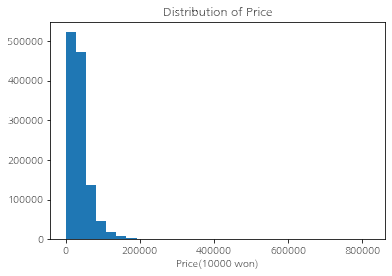

In [ ]:
# train price
plt.figure()
plt.hist(train_df['transaction_real_price'], bins=30)
plt.xlabel('Price(10000 won)')
plt.title('Distribution of Price')
plt.show()

- 가격의 분포가 매우 왼쪽으로 치우친 것을 확인할 수 있음
- 타겟 변수의 이상치가 회귀모형을 사용한 예측에 큰 영향을 줄 수 있음
    - 로그 변환으로 정규화한뒤, 나중에 다시 역변환

In [ ]:
# 가격 로그 변환 후 원래 가격 따로 저장
all_df['log_price'] = np.log1p(all_df['transaction_real_price'])
real_price = all_df['transaction_real_price'] # 원래 가격
#train_y = real_price[:train_df.shape[0]] # train 데이터의 가격
#test_y = real_price[train_df.shape[0]:] # test 데이터의 가격
all_df.drop('transaction_real_price', axis=1, inplace=True)
all_df.head(1)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,apt_counts,top10,transformed,log_price
0,0,7622,서울특별시,138,0,84.82,41,0,2,13.0,0,False,10.532123


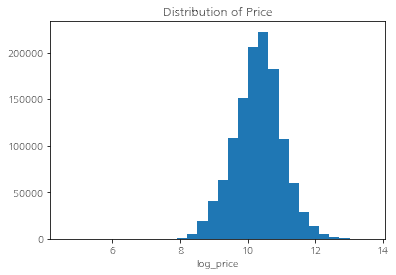

In [ ]:
# train price
plt.figure()
plt.hist(all_df['log_price'], bins=30)
plt.xlabel('log_price')
plt.title('Distribution of Price')
plt.show()

### Area

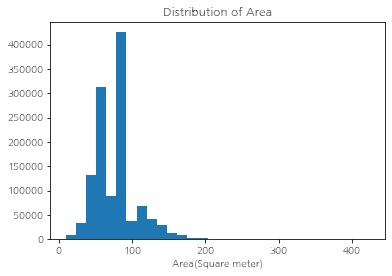

In [ ]:
# train area
plt.figure()
plt.hist(train_df['exclusive_use_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

In [ ]:
# 면적 로그 변환 후 원래 면적 따로 저장
all_df['log_area'] = np.log1p(all_df['exclusive_use_area'])
area = all_df['exclusive_use_area'] # 원래 가격
all_df.drop('exclusive_use_area', axis=1, inplace=True)
all_df.head(1)

,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,apt_counts,top10,transformed,log_price,log_area
0,0,7622,서울특별시,138,0,41,0,2,13.0,0,False,10.532123,4.452252


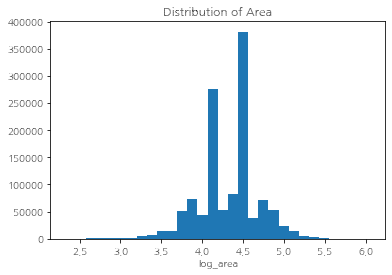

In [ ]:

plt.figure()
plt.hist(all_df['log_area'], bins=30)
plt.xlabel('log_area')
plt.title('Distribution of Area')
plt.show()

### Encoding

In [ ]:
def label_encoder(col):
    le = LabelEncoder()
    return le.fit_transform(col)
ohe_col = ['city']
drop_col = ['transaction_id', 'apartment_id', 'city', 'apt_counts', 'transformed']

ohe_columns = pd.get_dummies(all_df[ohe_col])


In [ ]:
all_df.head(1)

,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,apt_counts,top10,transformed,log_price,log_area
0,0,7622,서울특별시,138,0,41,0,2,13.0,0,False,10.532123,4.452252


In [ ]:
all_df = pd.concat([all_df.drop(drop_col, axis=1), ohe_columns], axis=1)
all_df.head()

,dong,apt,year_of_completion,transaction_year_month,floor,top10,log_price,log_area,city_부산광역시,city_서울특별시
0,138,0,41,0,2,0,10.532123,4.452252,0,1
1,65,0,12,0,6,0,9.903538,4.606869,0,1
2,65,0,46,0,6,0,10.558439,4.451319,0,1
3,13,0,42,0,15,0,11.678448,4.993082,0,1
4,13,0,43,0,3,0,11.695255,5.275202,0,1


In [ ]:
all_df.shape

(1222016, 10)

In [ ]:
all_df.to_csv(PATH + 'all_df.csv', index=False)

## 전처리 생략 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
!pip install https://s3-us-west-2.amazonaws.com/xgboost-nightly-builds/xgboost-1.4.0_SNAPSHOT%2B4224c08cacceba3f83f90e387c07aa6205a83bfa-py3-none-manylinux2010_x86_64.whl
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  Ridge, LassoLarsIC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# After running
! git clone --recursive https://github.com/Microsoft/LightGBM
#You can run this oneliner which will build and compile LightGBM with GPU enabled in colab:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;    
import lightgbm as lgb
import re
!pip install optuna -q
import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.externals import joblib
import pickle

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm
!apt-get update -qq
!apt-get install fonts-nanum* -qq
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


     |████████████████████████████████| 166.7MB 44kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Cloning into 'LightGBM'...
remote: Enumerating objects: 22446, done.
remote: Total 22446 (delta 0), reused 0 (delta 0), pack-reused 22446
Receiving objects: 100% (22446/22446), 17.30 MiB | 14.20 MiB/s, done.
Resolving deltas: 100% (16483/16483), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'
Cloning into '/content/LightGBM/external_libs/compute'...
remote: Enumerating objects: 21731, done. 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumGothic Eco


In [ ]:
PATH = '/content/drive/MyDrive/input/dataminingTP/'
train_df = pd.read_csv(PATH + 'train_df_regex.csv')
all_df = pd.read_csv(PATH + 'all_df.csv')
all_df_wo_apt = all_df.drop('apt', axis=1)

In [ ]:
all_df.head()

,dong,apt,year_of_completion,transaction_year_month,floor,top10,log_price,log_area,city_부산광역시,city_서울특별시
0,138,0,41,0,2,0,10.532123,4.452252,0,1
1,65,0,12,0,6,0,9.903538,4.606869,0,1
2,65,0,46,0,6,0,10.558439,4.451319,0,1
3,13,0,42,0,15,0,11.678448,4.993082,0,1
4,13,0,43,0,3,0,11.695255,5.275202,0,1


In [ ]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222016 entries, 0 to 1222015
Data columns (total 10 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   dong                    1222016 non-null  int64  
 1   apt                     1222016 non-null  int64  
 2   year_of_completion      1222016 non-null  int64  
 3   transaction_year_month  1222016 non-null  int64  
 4   floor                   1222016 non-null  int64  
 5   top10                   1222016 non-null  int64  
 6   log_price               1216553 non-null  float64
 7   log_area                1222016 non-null  float64
 8   city_부산광역시              1222016 non-null  int64  
 9   city_서울특별시              1222016 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 93.2 MB


In [ ]:
all_df.describe()

,dong,apt,year_of_completion,transaction_year_month,floor,top10,log_price,log_area,city_부산광역시,city_서울특별시
count,1.222016e+06,1.222016e+06,1.222016e+06,1.222016e+06,1.222016e+06,1.222016e+06,1.216553e+06,1.222016e+06,1.222016e+06,1.222016e+06
mean,2.407773e+02,4.388966e+00,3.730611e+01,6.461461e+01,9.338479e+00,1.234329e-01,1.030509e+01,4.306129e+00,3.893730e-01,6.106270e-01
std,1.267679e+02,7.124980e+00,8.947398e+00,3.519266e+01,6.604638e+00,3.289336e-01,7.054740e-01,3.688630e-01,4.876083e-01,4.876083e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-4.000000e+00,0.000000e+00,4.615121e+00,2.328253e+00,0.000000e+00,0.000000e+00
25%,1.300000e+02,0.000000e+00,3.200000e+01,3.300000e+01,4.000000e+00,0.000000e+00,9.852247e+00,4.106932e+00,0.000000e+00,0.000000e+00
50%,2.580000e+02,0.000000e+00,3.800000e+01,7.200000e+01,8.000000e+00,0.000000e+00,1.033854e+01,4.423648e+00,0.000000e+00,1.000000e+00
75%,3.380000e+02,6.000000e+00,4.400000e+01,9.400000e+01,1.300000e+01,0.000000e+00,1.075792e+01,4.453998e+00,1.000000e+00,1.000000e+00
max,4.760000e+02,3.400000e+01,5.600000e+01,1.190000e+02,8.000000e+01,1.000000e+00,1.361706e+01,6.052842e+00,1.000000e+00,1.000000e+00


In [ ]:
all_df.drop('apt', axis=1, inplace=True)
train_df = all_df[:train_df.shape[0]]
train_y = train_df['log_price']
train_X = train_df.drop('log_price', axis=1)
test_df = all_df[train_df.shape[0]:].drop('log_price', axis=1)
print(train_df.shape, test_df.shape, train_X.shape, train_y.shape)

(1216553, 9) (5463, 8) (1216553, 8) (1216553,)


In [ ]:
train_X.head(1)

,dong,year_of_completion,transaction_year_month,floor,top10,log_area,city_부산광역시,city_서울특별시
0,138,41,0,2,0,4.452252,0,1


In [ ]:
train_y.head(1)

0    10.532123
Name: log_price, dtype: float64

In [ ]:
train_df.head(1)

,dong,apt,year_of_completion,transaction_year_month,floor,top10,log_price,log_area,city_부산광역시,city_서울특별시
0,138,0,41,0,2,0,10.532123,4.452252,0,1


In [ ]:
test_df.head(1)

,dong,apt,year_of_completion,transaction_year_month,floor,top10,log_area,city_부산광역시,city_서울특별시
1216553,51,0,41,118,2,0,3.598681,0,1



## Modeling

### Linear Regression

In [ ]:
reg = LinearRegression().fit(train_X, train_y)
reg.score(train_X, train_y) # R^2

0.8498313309398801

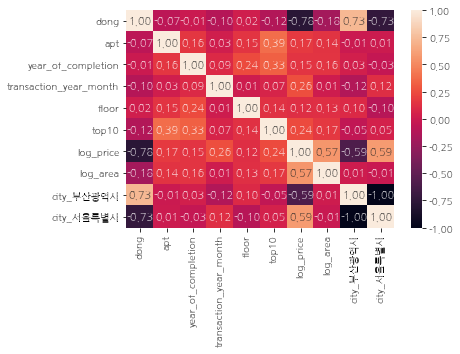

In [ ]:
sns.heatmap(train_df.corr(), annot=True, fmt='.2f', annot_kws={"fontsize":11})
plt.show()

### Set RMSE Score

In [ ]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmse_cv(model):
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    for i, (train_index, test_index) in enumerate(tscv.split(train_X), start=1):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return type(model).__name__, rmse_list

def print_rmse_score(model):
    model_name, score = rmse_cv(model)
    for i, r in tqdm(enumerate(score, start=1), leave=True):
        if i == 1:
            print('\n')
            print(f'{i} FOLDS: {model_name} RMSE: {r:.4f}')
        else:
            print(f'{i} FOLDS: {model_name} RMSE: {r:.4f}')
    print(f'\n{model_name} mean RMSE: {np.mean(score):.4f}')
    print('='*40)

In [ ]:
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)

# DTree의 스코어가 가장 높았으므로 DTree 부터 시작
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05,
                             max_depth=3, min_child_weight=1.7817, n_estimators=1000,
                             reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213,
                             silent=1, random_state=1, nthread=-1)
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, 
                              n_estimators=720, max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319, feature_fraction_seed=9,
                              bagging_seed=9, min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

In [ ]:
score = []
for model in [reg, ridge, lasso, Enet, DTree]:
    print_rmse_score(model)

10it [00:00, 11878.52it/s]




1 FOLDS: LinearRegression RMSE: 0.1978
2 FOLDS: LinearRegression RMSE: 0.2504
3 FOLDS: LinearRegression RMSE: 0.2150
4 FOLDS: LinearRegression RMSE: 0.3570
5 FOLDS: LinearRegression RMSE: 0.3425
6 FOLDS: LinearRegression RMSE: 0.3479
7 FOLDS: LinearRegression RMSE: 0.3381
8 FOLDS: LinearRegression RMSE: 0.2905
9 FOLDS: LinearRegression RMSE: 0.2620
10 FOLDS: LinearRegression RMSE: 0.2850

LinearRegression mean RMSE: 0.2886


10it [00:00, 2202.43it/s]




1 FOLDS: Ridge RMSE: 0.1978
2 FOLDS: Ridge RMSE: 0.2504
3 FOLDS: Ridge RMSE: 0.2150
4 FOLDS: Ridge RMSE: 0.3570
5 FOLDS: Ridge RMSE: 0.3425
6 FOLDS: Ridge RMSE: 0.3479
7 FOLDS: Ridge RMSE: 0.3381
8 FOLDS: Ridge RMSE: 0.2905
9 FOLDS: Ridge RMSE: 0.2620
10 FOLDS: Ridge RMSE: 0.2850

Ridge mean RMSE: 0.2886


10it [00:00, 2205.56it/s]




1 FOLDS: Lasso RMSE: 0.2008
2 FOLDS: Lasso RMSE: 0.2531
3 FOLDS: Lasso RMSE: 0.2209
4 FOLDS: Lasso RMSE: 0.3633
5 FOLDS: Lasso RMSE: 0.3362
6 FOLDS: Lasso RMSE: 0.4172
7 FOLDS: Lasso RMSE: 0.3588
8 FOLDS: Lasso RMSE: 0.3049
9 FOLDS: Lasso RMSE: 0.2640
10 FOLDS: Lasso RMSE: 0.2790

Lasso mean RMSE: 0.2998


10it [00:00, 1378.07it/s]




1 FOLDS: ElasticNet RMSE: 0.2076
2 FOLDS: ElasticNet RMSE: 0.2530
3 FOLDS: ElasticNet RMSE: 0.2194
4 FOLDS: ElasticNet RMSE: 0.3666
5 FOLDS: ElasticNet RMSE: 0.3339
6 FOLDS: ElasticNet RMSE: 0.3691
7 FOLDS: ElasticNet RMSE: 0.3566
8 FOLDS: ElasticNet RMSE: 0.3040
9 FOLDS: ElasticNet RMSE: 0.2679
10 FOLDS: ElasticNet RMSE: 0.2803

ElasticNet mean RMSE: 0.2958


10it [00:00, 7644.08it/s]



1 FOLDS: DecisionTreeRegressor RMSE: 0.1897
2 FOLDS: DecisionTreeRegressor RMSE: 0.2702
3 FOLDS: DecisionTreeRegressor RMSE: 0.2256
4 FOLDS: DecisionTreeRegressor RMSE: 0.3592
5 FOLDS: DecisionTreeRegressor RMSE: 0.3874
6 FOLDS: DecisionTreeRegressor RMSE: 0.3512
7 FOLDS: DecisionTreeRegressor RMSE: 0.3719
8 FOLDS: DecisionTreeRegressor RMSE: 0.3128
9 FOLDS: DecisionTreeRegressor RMSE: 0.2991
10 FOLDS: DecisionTreeRegressor RMSE: 0.3352

DecisionTreeRegressor mean RMSE: 0.3102


In [ ]:
for model in [model_xgb, model_lgb]:
    print_rmse_score(model)

[10:20:28] WARNING: ../src/learner.cc:572: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[10:20:43] WARNING: ../src/learner.cc:572: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[10:21:09] WARNING: ../src/learner.cc:572: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[10:21:49] WARNING: ../src/learner.cc:572: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[10:22:42] WARNING: ../src/learner.cc:572: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[10:23:48] WARNING: ../src/learner.cc:572: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[10:25:08] WARNING: ../src/learner.cc:572: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[10:26:40] WARNING: ../src/learner.cc:572: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[10:28:25] WARNING: ../src/learner.cc:572: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



[10:30:23] WARNING: ../src/learner.cc:572: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

10it [00:00, 2178.75it/s]




1 FOLDS: XGBRegressor RMSE: 0.1941
2 FOLDS: XGBRegressor RMSE: 0.2233
3 FOLDS: XGBRegressor RMSE: 0.1954
4 FOLDS: XGBRegressor RMSE: 0.3255
5 FOLDS: XGBRegressor RMSE: 0.3466
6 FOLDS: XGBRegressor RMSE: 0.2507
7 FOLDS: XGBRegressor RMSE: 0.2532
8 FOLDS: XGBRegressor RMSE: 0.2130
9 FOLDS: XGBRegressor RMSE: 0.2430
10 FOLDS: XGBRegressor RMSE: 0.1878

XGBRegressor mean RMSE: 0.2433
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[L

10it [00:00, 12028.40it/s]



1 FOLDS: LGBMRegressor RMSE: 0.3332
2 FOLDS: LGBMRegressor RMSE: 0.3558
3 FOLDS: LGBMRegressor RMSE: 0.3264
4 FOLDS: LGBMRegressor RMSE: 0.4496
5 FOLDS: LGBMRegressor RMSE: 0.3751
6 FOLDS: LGBMRegressor RMSE: 0.2544
7 FOLDS: LGBMRegressor RMSE: 0.2692
8 FOLDS: LGBMRegressor RMSE: 0.2333
9 FOLDS: LGBMRegressor RMSE: 0.2241
10 FOLDS: LGBMRegressor RMSE: 0.2124

LGBMRegressor mean RMSE: 0.3033


In [ ]:
score = [0.2881, 0.2881, 0.2987, 0.2950, 0.3103, 0.2749, 0.2390, 0.2419]
model = ['Linear Regression', 'Ridge', 'Lasso', "ElasticNet", 'DecisionTree','RandomForest', 'XGBoost', 'LightGBM']

result_df = pd.DataFrame({'Model': model, 'Score': score}).sort_values(by='Score', ascending=True).reset_index(drop=True)
result_df.head(8)


,Model,Score
0,XGBoost,0.2300
1,LightGBM,0.2340
2,RandomForest,0.2749
3,Linear Regression,0.2871
4,Ridge,0.2871
5,ElasticNet,0.2941
6,Lasso,0.2977
7,DecisionTree,0.3100


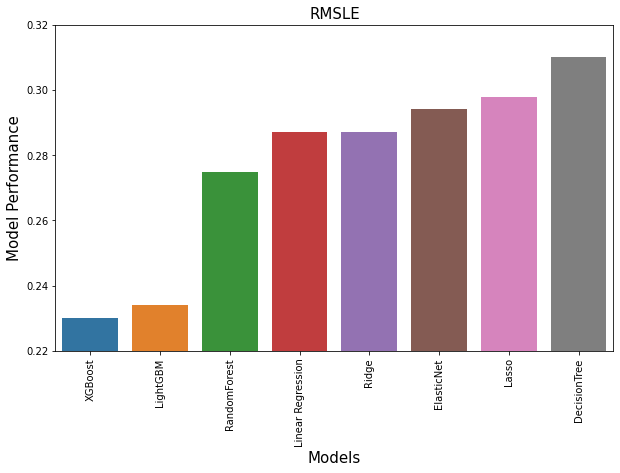

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.22, 0.32)
plt.title('RMSLE', fontsize=15)
plt.show()

- xgboost 하이퍼 파라미터 튜닝 진행

### Hyperparameter Tuning

In [ ]:
cut = int(len(train_df)*0.8)
h_train = train_df[:cut]
h_valid = train_df[cut:]

h_train_X = h_train.drop('log_price', axis=1)
h_train_y = h_train['log_price']
h_valid_X = h_valid.drop('log_price', axis=1)
h_valid_y = h_valid['log_price']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(973242, 8) (973242,) (243311, 8) (243311,)


#### XGBoost optuna

In [ ]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)
n_repeats=3

def objective(trial):
    dtrain = xgb.DMatrix(h_train_X, label=h_train_y)
    dtest = xgb.DMatrix(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'reg:squarederror', # 회귀
         'eval_metric': 'rmse',
         "xgb_gpu_hist": 1,
         'verbosity': 0,
         'booster': 'gbtree', # gradient boosting decision tree
         'lambda': trial.suggest_loguniform('lambda', 1e-8, 1),
         'alpha': trial.suggest_loguniform('alpha', 1e-8, 1),
         'max_depth': trial.suggest_int('max_depth',3, 9),
         'learning_rate': 0.01,
         "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
         "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
         'n_estimators': trial.suggest_int('n_estimators', 700, 1500),
         'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
         'subsample': trial.suggest_loguniform('subsample', 0.4, 1)
    }

    model = xgb.XGBRegressor(**param)
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")
    xgb_2 = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0,
                      eval_metric='rmse', callbacks=[pruning_callback])

    rmse = RMSE(h_valid_y, xgb_2.predict(h_valid_X))
    return rmse
        
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective, n_trials=50)

[I 2021-06-15 10:35:02,076] A new study created in memory with name: no-name-5649ea51-458d-4105-a32e-6baeb2107626
/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

[I 2021-06-15 10:40:07,230] Trial 0 finished with value: 0.20655606098580012 and parameters: {'lambda': 0.014810344004555135, 'alpha': 1.4656004675652718e-08, 'max_depth': 7, 'eta': 0.00978207662259244, 'gamma': 9.728728830009641e-05, 'n_estimators': 880, 'min_child_weight': 2, 'subsample': 0.8029815922829752}. Best is trial 0 with value: 0.20655606098580012.
/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

[I 2021-06-15 10:46:39,391] Trial 1 finished with value: 0.20419357744162184 and parameters: {'lambda': 2.253651157496

In [ ]:
print('Best Trial: score {},\nparams {}'.format(study_xgb.best_trial.value, study_xgb.best_trial.params))

Best Trial: score 0.20019178035912613,
params {'lambda': 2.2741802872089376e-05, 'alpha': 0.00029229369026373484, 'max_depth': 9, 'eta': 0.05598548865779304, 'gamma': 0.005501346075473814, 'n_estimators': 1181, 'min_child_weight': 10, 'subsample': 0.4150834316309578}


In [ ]:
optuna.visualization.plot_param_importances(study_xgb)

#### XGBoost Submission

In [ ]:
trial = study_xgb.best_trial
xgb_params = trial.params
xgb_params

{'alpha': 0.00029229369026373484,
 'eta': 0.05598548865779304,
 'gamma': 0.005501346075473814,
 'lambda': 2.2741802872089376e-05,
 'max_depth': 9,
 'min_child_weight': 10,
 'n_estimators': 1181,
 'subsample': 0.4150834316309578}

In [ ]:
xgb_params = {'lambda': 4.331620560539036e-05,
 'alpha': 7.797421436374639e-06,
 'max_depth': 9,
 'eta': 1.907242878319554e-05,
 'gamma': 1.1214312618970705e-05,
 'n_estimators': 868,
 'min_child_weight': 4,
 'subsample': 0.6453218391676352}

In [ ]:
final_xgb_model = xgb.XGBRegressor(**xgb_params)
final_xgb_model.fit(train_X, train_y, eval_metric='rmse')
final_xgb_pred = final_xgb_model.predict(test_df)

/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [ ]:
final_xgb_pred

array([10.310147 ,  9.4687805,  9.453366 , ..., 10.989199 , 10.569776 ,
        9.7787075], dtype=float32)

(array([   6.,   46.,  218.,  610., 1228., 1699., 1025.,  495.,  105.,
          31.]),
 array([ 7.901731,  8.412289,  8.922846,  9.433404,  9.943961, 10.454518,
        10.965076, 11.475634, 11.986191, 12.496749, 13.007306],
       dtype=float32),
 <a list of 10 Patch objects>)

findfont: Font family ['NanumGothic Eco'] not found. Falling back to DejaVu Sans.


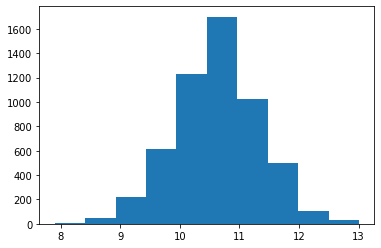

In [ ]:
plt.hist(final_xgb_pred)

<BarContainer object of 9 artists>

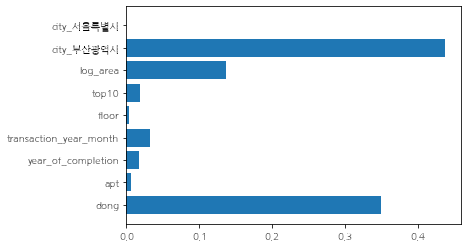

In [ ]:
plt.barh(train_X.columns, final_xgb_model.feature_importances_)

In [ ]:
final_pred_sub = np.expm1(final_xgb_pred)
final_pred_sub

array([30034.86 , 12948.086, 12750.017, ..., 59229.902, 38938.934,
       17652.82 ], dtype=float32)

In [ ]:
sub = pd.read_csv(PATH + 'test.csv')
sub_df = pd.DataFrame({'transaction_id': sub['transaction_id'], 'transaction_real_price': final_pred_sub})
sub_df

,transaction_id,transaction_real_price
0,1145756,30034.859375
1,1198704,12948.085938
2,1222384,12750.016602
3,1179897,118555.234375
4,1223091,45606.089844
...,...,...
5458,1174640,69404.226562
5459,1175575,197598.281250
5460,1157024,59229.902344
5461,1136863,38938.933594


In [ ]:
sub_df.to_csv(PATH + 'submission_xgb_wo_apt.csv', index=False)

![image](https://user-images.githubusercontent.com/68543150/120895433-e0266880-c657-11eb-8380-58ccf01a6c06.png)

## without apt

In [ ]:
train_df2 = all_df_wo_apt[:train_df.shape[0]]
train_y2 = train_df2['log_price']
train_X2 = train_df2.drop('log_price', axis=1)
test_df2 = all_df[train_df2.shape[0]:].drop('log_price', axis=1)
print(train_df2.shape, test_df2.shape, train_X2.shape, train_y2.shape)

(1216553, 9) (5463, 9) (1216553, 8) (1216553,)


In [ ]:
reg = LinearRegression().fit(train_X2, train_y2)
reg.score(train_X2, train_y2) # R^2

0.8498313309398801

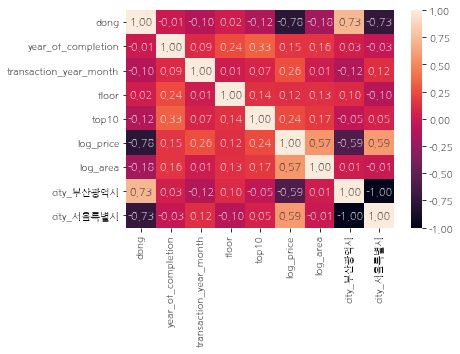

In [ ]:
sns.heatmap(train_df2.corr(), annot=True, fmt='.2f', annot_kws={"fontsize":11})
plt.show()

#### LGBM optuna

In [ ]:
 from optuna.samplers import TPESampler

 sampler = TPESampler(seed=10)
 def objective(trial):

     param = {
         'objective': 'regression', # 회귀
         'metric': 'rmse', 
         'verbosity': -1,
         'device': 'gpu',
         'boosting_type': 'gbdt', # gradient boosting decision tree
         'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 1),
         'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 1),
         'num_leaves': trial.suggest_int('num_leaves', 2, 400),
         'max_depth': trial.suggest_int('max_depth',3, 9),
         'learning_rate': 0.01,
         'n_estimators': trial.suggest_int('n_estimators', 700, 5000),
         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
         'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
     }

     lgbm_regr = lgb.LGBMRegressor(**param)
     gbm_2 = lgbm_regr.fit(h_train_X, h_train_y , eval_set = [(h_valid_X, h_valid_y)], verbose=False)
     rmse = RMSE(h_valid_y, gbm_2.predict(h_valid_X))
     return rmse

study = optuna.create_study(direction='minimize', sampler=sampler)
study.optimize(objective, n_trials=50)

[I 2021-06-15 08:12:08,976] A new study created in memory with name: no-name-02da8e1c-e920-46fe-97d7-3b5ca9a84380


[LightGBM] [Warning] feature_fraction is set=0.5348779873185086, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5348779873185086
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=1.4656004675652718e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4656004675652718e-08
[LightGBM] [Warning] bagging_fraction is set=0.5188377188557745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5188377188557745
[LightGBM] [Warning] lambda_l1 is set=0.014810344004555135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014810344004555135


[I 2021-06-15 08:15:51,017] Trial 0 finished with value: 0.19243689085209237 and parameters: {'lambda_l1': 0.014810344004555135, 'lambda_l2': 1.4656004675652718e-08, 'num_leaves': 254, 'max_depth': 8, 'n_estimators': 2844, 'feature_fraction': 0.5348779873185086, 'bagging_fraction': 0.5188377188557745, 'bagging_freq': 6, 'min_child_samples': 21}. Best is trial 0 with value: 0.19243689085209237.


[LightGBM] [Warning] feature_fraction is set=0.8875725769912681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8875725769912681
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.003040034742832493, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003040034742832493
[LightGBM] [Warning] bagging_fraction is set=0.7675156400976328, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7675156400976328
[LightGBM] [Warning] lambda_l1 is set=5.090008568091192e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.090008568091192e-08


[I 2021-06-15 08:17:21,896] Trial 1 finished with value: 0.22266512750423284 and parameters: {'lambda_l1': 5.090008568091192e-08, 'lambda_l2': 0.003040034742832493, 'num_leaves': 382, 'max_depth': 3, 'n_estimators': 2902, 'feature_fraction': 0.8875725769912681, 'bagging_fraction': 0.7675156400976328, 'bagging_freq': 6, 'min_child_samples': 33}. Best is trial 0 with value: 0.19243689085209237.


[LightGBM] [Warning] feature_fraction is set=0.8044801690398071, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044801690398071
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.005207224083783965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005207224083783965
[LightGBM] [Warning] bagging_fraction is set=0.6650999046537976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6650999046537976
[LightGBM] [Warning] lambda_l1 is set=0.21988367156694333, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21988367156694333


[I 2021-06-15 08:18:38,901] Trial 2 finished with value: 0.22233033182675382 and parameters: {'lambda_l1': 0.21988367156694333, 'lambda_l2': 0.005207224083783965, 'num_leaves': 218, 'max_depth': 3, 'n_estimators': 2305, 'feature_fraction': 0.8044801690398071, 'bagging_fraction': 0.6650999046537976, 'bagging_freq': 4, 'min_child_samples': 64}. Best is trial 0 with value: 0.19243689085209237.


[LightGBM] [Warning] feature_fraction is set=0.945189328485201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.945189328485201
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.0015965313667163816, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015965313667163816
[LightGBM] [Warning] bagging_fraction is set=0.5915416533931271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5915416533931271
[LightGBM] [Warning] lambda_l1 is set=0.00012738137732610437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00012738137732610437


[I 2021-06-15 08:21:45,437] Trial 3 finished with value: 0.18965380138702537 and parameters: {'lambda_l1': 0.00012738137732610437, 'lambda_l2': 0.0015965313667163816, 'num_leaves': 241, 'max_depth': 8, 'n_estimators': 2943, 'feature_fraction': 0.945189328485201, 'bagging_fraction': 0.5915416533931271, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 3 with value: 0.18965380138702537.


[LightGBM] [Warning] feature_fraction is set=0.8915721974020412, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8915721974020412
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.042604022999246406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.042604022999246406
[LightGBM] [Warning] bagging_fraction is set=0.5193685238072874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5193685238072874
[LightGBM] [Warning] lambda_l1 is set=8.163471763379958e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.163471763379958e-08


[I 2021-06-15 08:23:44,582] Trial 4 finished with value: 0.2076046256904828 and parameters: {'lambda_l1': 8.163471763379958e-08, 'lambda_l2': 0.042604022999246406, 'num_leaves': 20, 'max_depth': 7, 'n_estimators': 3055, 'feature_fraction': 0.8915721974020412, 'bagging_fraction': 0.5193685238072874, 'bagging_freq': 6, 'min_child_samples': 38}. Best is trial 3 with value: 0.18965380138702537.


[LightGBM] [Warning] feature_fraction is set=0.6355175463679523, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6355175463679523
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=2.3318126555538504e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3318126555538504e-06
[LightGBM] [Warning] bagging_fraction is set=0.4560762247351902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4560762247351902
[LightGBM] [Warning] lambda_l1 is set=0.010893853540963833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010893853540963833


[I 2021-06-15 08:24:47,474] Trial 5 finished with value: 0.20912770183630566 and parameters: {'lambda_l1': 0.010893853540963833, 'lambda_l2': 2.3318126555538504e-06, 'num_leaves': 354, 'max_depth': 5, 'n_estimators': 1409, 'feature_fraction': 0.6355175463679523, 'bagging_fraction': 0.4560762247351902, 'bagging_freq': 6, 'min_child_samples': 19}. Best is trial 3 with value: 0.18965380138702537.


[LightGBM] [Warning] feature_fraction is set=0.5508244805242356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5508244805242356
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.3581671060741645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3581671060741645
[LightGBM] [Warning] bagging_fraction is set=0.7584229889385306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7584229889385306
[LightGBM] [Warning] lambda_l1 is set=1.1828116394242723e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1828116394242723e-05


[I 2021-06-15 08:28:47,055] Trial 6 finished with value: 0.19808753442579072 and parameters: {'lambda_l1': 1.1828116394242723e-05, 'lambda_l2': 0.3581671060741645, 'num_leaves': 396, 'max_depth': 6, 'n_estimators': 4253, 'feature_fraction': 0.5508244805242356, 'bagging_fraction': 0.7584229889385306, 'bagging_freq': 7, 'min_child_samples': 56}. Best is trial 3 with value: 0.18965380138702537.


[LightGBM] [Warning] feature_fraction is set=0.5984315871892792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5984315871892792
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.0618360930258403e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0618360930258403e-08
[LightGBM] [Warning] bagging_fraction is set=0.8642981777263575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8642981777263575
[LightGBM] [Warning] lambda_l1 is set=0.0005267577135346555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0005267577135346555


[I 2021-06-15 08:29:39,025] Trial 7 finished with value: 0.21920545434324523 and parameters: {'lambda_l1': 0.0005267577135346555, 'lambda_l2': 2.0618360930258403e-08, 'num_leaves': 144, 'max_depth': 3, 'n_estimators': 2013, 'feature_fraction': 0.5984315871892792, 'bagging_fraction': 0.8642981777263575, 'bagging_freq': 1, 'min_child_samples': 46}. Best is trial 3 with value: 0.18965380138702537.


[LightGBM] [Warning] feature_fraction is set=0.8579443522862087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8579443522862087
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0012357458041729475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012357458041729475
[LightGBM] [Warning] bagging_fraction is set=0.926857985634915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.926857985634915
[LightGBM] [Warning] lambda_l1 is set=3.3068536483753737e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3068536483753737e-06


[I 2021-06-15 08:32:38,917] Trial 8 finished with value: 0.21881997937636535 and parameters: {'lambda_l1': 3.3068536483753737e-06, 'lambda_l2': 0.0012357458041729475, 'num_leaves': 140, 'max_depth': 3, 'n_estimators': 4484, 'feature_fraction': 0.8579443522862087, 'bagging_fraction': 0.926857985634915, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 3 with value: 0.18965380138702537.


[LightGBM] [Warning] feature_fraction is set=0.5818375363906209, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5818375363906209
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.0006063078395671604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006063078395671604
[LightGBM] [Warning] bagging_fraction is set=0.5452455252421164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5452455252421164
[LightGBM] [Warning] lambda_l1 is set=0.0001281542517497079, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001281542517497079


[I 2021-06-15 08:33:18,713] Trial 9 finished with value: 0.2123716540167289 and parameters: {'lambda_l1': 0.0001281542517497079, 'lambda_l2': 0.0006063078395671604, 'num_leaves': 106, 'max_depth': 5, 'n_estimators': 809, 'feature_fraction': 0.5818375363906209, 'bagging_fraction': 0.5452455252421164, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 3 with value: 0.18965380138702537.


[LightGBM] [Warning] feature_fraction is set=0.9829499664972009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9829499664972009
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=2.1915803658880983e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1915803658880983e-05
[LightGBM] [Warning] bagging_fraction is set=0.6332740884655743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6332740884655743
[LightGBM] [Warning] lambda_l1 is set=2.8850899106925093e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8850899106925093e-06


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-27-80a3dc6cd2b6>", line 30, in <module>
    study.optimize(objective, n_trials=50)
  File "/usr/local/lib/python3.7/dist-packages/optuna/study.py", line 410, in optimize
    show_progress_bar=show_progress_bar,
  File "/usr/local/lib/python3.7/dist-packages/optuna/_optimize.py", line 75, in _optimize
    progress_bar=progress_bar,
  File "/usr/local/lib/python3.7/dist-packages/optuna/_optimize.py", line 162, in _optimize_sequential
    trial = _run_trial(study, func, catch)
  File "/usr/local/lib/python3.7/dist-packages/optuna/_optimize.py", line 216, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-27-80a3dc6cd2b6>", line 25, in objective
    gbm_2 = lgbm_regr.fit(h_train_X, h_train_y , eval_set = [(h_valid_X, h_valid_y)], verbose=False)
  File "/usr

KeyboardInterrupt: ignored

In [ ]:
print('Best Trial: score {},\nparams {}'.format(study.best_trial.value, study.best_trial.params))

In [ ]:
lgb_params = {'lambda_l1': 8.181119779520876e-06, 
              'lambda_l2': 0.0016235067963037198,
              'num_leaves': 294, 
              'max_depth': 9, 
              'n_estimators': 4055, 
              'feature_fraction': 0.908217019753265, 
              'bagging_fraction': 0.8448723506556448,
              'bagging_freq': 2,
              'min_child_samples': 28}

In [ ]:
optuna.visualization.plot_optimization_history(study)

#### LightGBM Submission

In [ ]:
final_lgb_model = lgb.LGBMRegressor(**lgb_params)
final_lgb_model.fit(train_X, train_y, eval_metric='rmse')
final_lgb_pred = final_lgb_model.predict(test_df)

[LightGBM] [Warning] feature_fraction is set=0.908217019753265, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.908217019753265
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l2 is set=0.0016235067963037198, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016235067963037198
[LightGBM] [Warning] lambda_l1 is set=8.181119779520876e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.181119779520876e-06
[LightGBM] [Warning] bagging_fraction is set=0.8448723506556448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8448723506556448


In [ ]:
final_lgb_pred

array([10.45239898,  9.44448255,  9.44968174, ..., 10.97149488,
       10.50841261,  9.60411715])

In [ ]:
final_pred_lgb_sub = np.expm1(final_lgb_pred)

sub = pd.read_csv(PATH + 'test.csv')
sub_df = pd.DataFrame({'transaction_id': sub['transaction_id'], 'transaction_real_price': final_pred_lgb_sub})
sub_df.to_csv('submission_lgb.csv', index=False)

![image](https://user-images.githubusercontent.com/68543150/120896946-be7caf80-c65e-11eb-857c-46fe0bfb2948.png)


## Ensemble

In [ ]:
final_Dtree_model = DecisionTreeRegressor(max_depth=6, min_samples_split=10, 
                                          min_samples_leaf=15, random_state=1)
final_rf_model = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1)

final_Dtree_model.fit(train_X, train_y)
final_rf_model.fit(train_X, train_y)

final_Dtree_pred = final_Dtree_model.predict(test_df)
final_rf_pred = final_rf_model.predict(test_df)

final_pred_Dtree_sub = np.expm1(final_Dtree_pred)
final_pred_rf_sub = np.expm1(final_rf_pred)

In [ ]:
en_sub = (final_pred_sub + final_pred_Dtree_sub + final_pred_lgb_sub + final_pred_rf_sub)/4
en_sub

array([28043.87458366, 18961.53876671, 17193.53846848, ...,
       69435.36542374, 50668.31090745, 18828.14104306])

In [ ]:
sub = pd.read_csv(PATH + 'test.csv')
sub_df = pd.DataFrame({'transaction_id': sub['transaction_id'], 'transaction_real_price': en_sub})
sub_df.to_csv('submission_ensemble.csv', index=False)

![image](https://user-images.githubusercontent.com/68543150/120897463-419f0500-c661-11eb-8995-ea566e0f4033.png)